In [ ]:
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import norm, lognorm
from scipy.stats import norm, qmc

# For custom tick formatting in your plots
from matplotlib.ticker import MultipleLocator, FuncFormatter

from typing import Union
import logging
import unittest
# For root finding (implied volatility, etc.)
from scipy.optimize import brentq


# Set up logging
logger = logging.getLogger(__name__)

# Describe the processes here - 
class Process:
    def __init__(self, S0, mu, sigma, T, num_steps, use_lognormal=False):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.T = T
        self.num_steps = num_steps
        self.dt = T / self.num_steps
        self.use_lognormal = use_lognormal
    
    def paths(self, num_paths):
        if self.use_lognormal:
            return self.analytical_gbm_paths(num_paths)
        else:
            return self.analytical_bachelier_paths(num_paths)

    def transition_density(self, S_next, S):
        mu = self.mu
        sigma = self.sigma
        dt = self.dt
        if self.use_lognormal:
            return Process.gbm_transition_density(S_next, S, mu, sigma, dt)
        else:
            return Process.bachelier_transition_density(S_next, S, mu, sigma, dt)

    def sample_next(self, S_t, dt, n_sample):
        if self.use_lognormal:
            return Process.sample_next_step_gbm(S_t, self.mu, self.sigma, dt, n_sample)
        else:
            return Process.sample_next_step_bachelier(S_t, self.mu, self.sigma, dt, n_sample)

    # --------------------------------------------------
    # Simulate paths - Internal
    # --------------------------------------------------
    
    @staticmethod
    def sample_dW(Nsteps, Npaths, method="sobol"):
        """ Generate Wiener increments dW for multiple SDE paths.
        
        Args:
            T (float): Total simulation time.
            Nsteps (int): Number of time steps per path.
            Npaths (int): Number of independent paths.
            method (str): Sampling method ('standard', 'antithetic', 'stratified', 
                        'lhs', 'qmc', 'importance').
        
        Returns:
            dW (numpy array): Array of shape (Npaths, Nsteps) representing Wiener increments.
        """
        Npaths = 2**(int(np.ceil(np.log2(Npaths))))
        print("Npaths is not a multiple / power of 2, this is a good conditions for various balancing schemes for variance reduction techniques - changing Npaths to %s" % Npaths)
        
        if method == "standard":
            return np.random.randn(Npaths, Nsteps)

        elif method == "antithetic":
            half_paths = Npaths // 2
            Z = np.random.randn(half_paths, Nsteps)
            dW = np.vstack([Z, -Z])  # Antithetic pairing
            if Npaths % 2 == 1:  # If odd, add one extra standard path
                dW = np.vstack([dW, np.random.randn(1, Nsteps)])
            np.random.shuffle(dW)  # Avoid pairing in sequence
            return dW

        elif method == "stratified":
            strata = (np.arange(Npaths)[:, None] + np.random.rand(Npaths, Nsteps)) / Npaths
            dW = norm.ppf(strata)  # Map to normal distribution
            np.random.shuffle(dW)  # Shuffle to remove ordering effects
            return dW

        elif method == "lhs":
            sampler = qmc.LatinHypercube(d=Nsteps)
            samples = sampler.random(Npaths)
            dW = norm.ppf(samples)  # Map uniform to normal
            return dW

        elif method == "qmc":
            n_total = Nsteps * Npaths
            sampler = qmc.Sobol(d=1, scramble=True)
            m = int(np.ceil(np.log2(n_total)))
            sobol_samples = sampler.random_base2(m=m)
            sobol_samples = sobol_samples[:n_total, 0]
            Z_uniform = sobol_samples.reshape((Npaths, Nsteps))
            dW = norm.ppf(Z_uniform)  # Map uniform to normal
            return dW

        elif method == "importance":
            mean_shift = 0.1  # Example mean shift
            std_scale = 0.8  # Example variance scaling
            return mean_shift + std_scale * np.random.randn(Npaths, Nsteps)

        else:
            raise ValueError("Invalid method. Choose from 'standard', 'antithetic', 'stratified', 'lhs', 'qmc', 'importance'.")
    
    def analytical_bachelier_paths(self, n_paths):
        S0 = self.S0 
        mu = self.mu
        sigma = self.sigma
        dt = self.dt
        n = self.num_steps
        T = self.T
        time_grid = np.linspace(0, T, n + 1)
        
        # Generate standard normal random numbers for all paths
        Z = np.random.normal(0, 1, (n + 1, n_paths))
        
        # Compute analytical solution for each path
        time_sqrt = sigma * np.sqrt(time_grid)[:, None]
        S = S0 + mu * time_grid[:, None] + sigma * np.sqrt(self.dt) * Z
        return S, time_grid  
    
    def analytical_gbm_paths(self, n_paths):
        
        """
        Simulates GBM paths using the analytical solution and QMC (Sobol sequence).

        Parameters:
            S0 (float): Initial stock price.
            mu (float): Drift.
            sigma (float): Volatility.
            T (float): Time horizon.
            N (int): Number of time steps.
            NPaths (int): Number of paths.

        Returns:
            np.ndarray: Simulated GBM paths of shape (NPaths, N+1).
            np.ndarray: Time grid.
        """
        S0 = self.S0 
        mu = self.mu
        sigma = self.sigma
        dt = self.dt
        N = self.num_steps
        NPaths = n_paths
        T = self.T
        
        time_grid = np.linspace(0, T, N+1)
        sqrt_t = np.sqrt(time_grid)  # For correct Brownian motion scaling

        # Generate QMC (Sobol) samples
        sobol = qmc.Sobol(d=N+1, scramble=True)  # d = N+1 since we need for all time steps
        u_qmc = sobol.random(NPaths)  # Generate (NPaths, N+1) uniform samples in [0,1]
        
        # Transform uniform samples to standard normal via inverse CDF
        Z_qmc = norm.ppf(u_qmc)
        dt = np.diff(time_grid)[0]
        
        # Compute GBM paths using the analytical solution
        # drift = (mu - 0.5 * sigma**2) * time_grid[None, :]
        # diffusion = sigma * sqrt_t[None, :] * Z_qmc  # Correct scaling for BM
        # S_qmc = S0 * np.exp(drift + diffusion)
        drift = (mu - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z_qmc[:, 1:]
        # use drift and diffusion to generate the paths
        S_qmc = np.zeros((NPaths, N+1))
        S_qmc[:, 0] = S0
        for i in range(1, N+1):
            S_qmc[:, i] = S_qmc[:, i-1] * np.exp(drift + diffusion[:, i-1])
        return S_qmc, time_grid

    # -------------------------------------------------
    # Transition Density - Internal
    # -------------------------------------------------
    @staticmethod
    def bachelier_transition_density(S_t_next, S_t, mu, sigma, dt):
        # Mean and variance for the normal distribution
        mean = S_t + mu * dt
        variance = sigma**2 * dt
        stddev = np.sqrt(variance)
        
        # Compute the normal distribution density at S_t_next
        pdf = stats.norm.pdf(S_t_next, loc=mean, scale=stddev)
        return pdf

    @staticmethod
    def gbm_transition_density(S_t_next, S_t, mu, sigma, dt):
        # Parameters for the log-normal distribution
        mean = np.log(S_t) + (mu - 0.5 * sigma**2) * dt
        variance = sigma**2 * dt
        stddev = np.sqrt(variance)
        
        # Compute the log-normal distribution density at S_t_next
        pdf = stats.lognorm.pdf(S_t_next, s=stddev, scale=np.exp(mean))
        return pdf

    # ---------------------------------------------------
    # Sample From Next Step - Internal
    # --------------------------------------------------- 

    @staticmethod
    def sample_next_step_bachelier(S_t, mu, sigma, dt, n_simulations):
        mean = S_t + mu * dt
        stddev = sigma * np.sqrt(dt)
        S_t_next = np.random.normal(loc=mean, scale=stddev, size=n_simulations)
        return S_t_next

    @staticmethod
    def sample_next_step_gbm(S_t, mu, sigma, dt, n_simulations):
        mean = np.log(S_t) + (mu - 0.5 * sigma**2) * dt
        stddev = sigma * np.sqrt(dt)
        S_t_next = np.random.lognormal(mean=mean, sigma=stddev, size=n_simulations)
        return S_t_next

    # ---------------------------------------------------
    # Test for correct simulation - Internal
    # ---------------------------------------------------
    def plot_theoretical_mean_var_vs_simulation_GBM(self, Simulations):
        n_paths, n_steps = Simulations.shape
        time_grid = np.linspace(0, self.T, n_steps)
        F = Simulations
        mu = self.mu
        sigma = self.sigma
        
        simulated_mean_qmc_analytical = np.mean(F, axis=0)
        simulated_variance_qmc_analytical = np.var(F, axis=0)
        theoretical_mean = 100 * np.exp(mu * time_grid)
        theoretical_variance = 100**2 * np.exp(2 * mu * time_grid) * (np.exp(sigma**2 * time_grid) - 1)
        
        # Plot Mean Comparison (Analytical QMC vs. Theoretical)
        plt.figure(figsize=(8, 5))
        plt.plot(time_grid, theoretical_mean, 'r--', label="Theoretical Mean")
        plt.plot(time_grid, simulated_mean_qmc_analytical, 'g-', alpha=0.7, label="Simulated Mean (QMC Analytical)")
        plt.xlabel("Time")
        plt.ylabel("Mean of S(t)")
        plt.title("GBM Analytical Solution: Simulated vs. Theoretical Mean (QMC)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot Variance Comparison (Analytical QMC vs. Theoretical)
        plt.figure(figsize=(8, 5))
        plt.plot(time_grid, theoretical_variance, 'r--', label="Theoretical Variance")
        plt.plot(time_grid, simulated_variance_qmc_analytical, 'g-', alpha=0.7, label="Simulated Variance (QMC Analytical)")
        plt.xlabel("Time")
        plt.ylabel("Variance of S(t)")
        plt.title("GBM Analytical Solution: Simulated vs. Theoretical Variance (QMC)")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        num_sample_paths = min(n_paths, 1000)
        plt.figure(figsize=(8, 5))
        plt.plot(time_grid, Simulations[:num_sample_paths, :].T, color='gray', alpha=0.1)
        plt.plot(time_grid, simulated_mean_qmc_analytical, 'r-', label="Mean Path")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.title("Sample Paths vs. Mean Path")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_mc_vs_theoretical_option_price_delta(self, Simulations):
        n_paths, num_steps = Simulations.shape
        time_grid = np.linspace(0, self.T, num_steps)
        F = Simulations
        mu = self.mu
        sigma = self.sigma
        
        times = []
        mc_price = []
        bs_price = []
        diff = []
        mc_delta = []
        bs_delta = []
        diff_delta = []
        opt_type = "C"
        for i in range(1, num_steps+1):
            call_price_mc = np.mean(np.maximum(F[:, i] - 100, 0)) * np.exp(-0 * time_grid[i])
            bsPrice = BlackScholesPricer(100, time_grid[i], "C", 0).price(100, 0, sigma)
            call_delta_mc = np.mean((F[:, i] > 100) * F[:, i] / 100) * np.exp(-0 * time_grid[i])
            put_delta_mc = -1 * np.mean((F[:, i] < 100) * F[:, i] / 100) * np.exp(-0 * time_grid[i])
            bsDeltaC = BlackScholesPricer(100, time_grid[i], "C", 0).delta(100, 0, sigma)
            bsDeltaP = BlackScholesPricer(100, time_grid[i], "P", 0).delta(100, 0, sigma)
            times.append(time_grid[i])
            mc_price.append(call_price_mc)
            bs_price.append(bsPrice)
            diff.append((call_price_mc - bsPrice)/bsPrice)
            if opt_type == "C":
                mc_delta.append(call_delta_mc)
                bs_delta.append(bsDeltaC)
                diff_delta.append(call_delta_mc - bsDeltaC)
            elif opt_type == "P":
                mc_delta.append(put_delta_mc)
                bs_delta.append(bsDeltaP)
                diff_delta.append(put_delta_mc - bsDeltaP)
            else:
                mc_delta.append(call_delta_mc + put_delta_mc)
                bs_delta.append(bsDeltaC + bsDeltaP)
                diff_delta.append((call_delta_mc + put_delta_mc - bsDeltaC - bsDeltaP))

        plt.figure()
        plt.plot(times, mc_price, label='MC Price')
        plt.plot(times, bs_price, label='BS Price')
        plt.legend()
        plt.show()

        # plt.figure()
        # plt.plot(times, diff, label='MC Price - BS Price')
        # plt.legend()
        # plt.show()

        plt.figure()
        plt.plot(times, mc_delta, label='MC Delta')
        plt.plot(times, bs_delta, label='BS Delta')
        plt.legend()
        plt.show()

        # plt.figure()
        # plt.plot(times, diff_delta, label='MC Delta - BS Delta')
        # plt.legend()
        # plt.show()

        # Make sure the terminal PnL is the same payoff as the call option 

    
# Define Various types of Surfaces here

class VolSurface:
    def __init__(self, sigma):
        self.sigma = sigma
    
    def get_volatility(self, K, t, F):
        return self.sigma


class Option(ABC):
    def __init__(self, K, T, type_="C", disc_rate=0) -> None:
        self.K = K  # Strike price
        self.T = T  # Time to
        self.type_ = 1 if type_ == "C" else -1
        self.r = disc_rate
    
    @abstractmethod
    def price(self, F, t, sigma:Union[float, VolSurface]):
        pass
    
    @abstractmethod
    def delta(self, F, t, sigma:Union[float, VolSurface]):
        pass
    
    @abstractmethod
    def gamma(self, F, t, sigma:Union[float, VolSurface]):
        pass
    
    @abstractmethod
    def theta(self, F, t, sigma:Union[float, VolSurface]):
        pass
    
    @abstractmethod
    def vega(self, F, t, sigma:Union[float, VolSurface]):
        pass
    
    def implied_volatility(self, F, t, price):
        # Calculate intrinsic value
        if self.type_ == 1:  # Call option
            intrinsic_value = max(F - self.K, 0)
        else:  # Put option
            intrinsic_value = max(self.K - F, 0)

        # Check if price is less than intrinsic value
        if price < intrinsic_value:
            print(f"Debug: Option price ({price}) is less than intrinsic value ({intrinsic_value}).")
            return np.nan
        
        def f(sigma):
            return self.price(F, t, sigma) - price

        return brentq(f, 0.0001, 10)
    
    def implied_volatility_delta(self, F, t, delta):
        """Find the implied volatility for a given level of Delta.
        
        Args:
            t (float): Time to maturity.
            delta (float): Target Delta value for which we want to find the implied volatility.
            F_ovrd (float, optional): Override for the forward price. Defaults to None.
        
        Returns:
            float: Implied volatility or NaN if not found or invalid input.
        """
        
        # Input validation
        if not (-1 <= delta <= 1):
            logger.error(f"Invalid delta value: {delta}. Delta should be between -1 and 1.")
            return np.nan
        
        if t < 0:
            logger.error(f"Invalid time to maturity: {t}. Time should be non-negative.")
            return np.nan

        if t > self.T: 
            logger.error(f"Valuation time is after expiry: {self.T} , ask for intrinsic value.")
            return np.nan

        # Define function to solve for sigma
        def f(sigma):
            try:
                return self.delta(F, t, sigma) - delta
            except Exception as e:
                logger.error(f"Error calculating delta with sigma={sigma}: {e}")
                raise

        # Use Brent's method to find the implied volatility
        try:
            implied_vol = brentq(f, 0.0001, 10)
            return implied_vol
        except ValueError as e:
            logger.error(f"Implied volatility not found: {e}")
            return np.nan
        except Exception as e:
            logger.error(f"An unexpected error occurred during volatility calculation: {e}")
            return np.nan

    
# Define the pricers here
class BachalierPricer(Option):
    def __init__(self, K, T, type_="C", disc_rate=0) -> None:
        self.K = K  # Strike price
        self.T = T  # Time to expiry
        self.type_ = 1 if type_ == "C" else -1  # 1 for Call, -1 for Put
        self.r = disc_rate  # Discount rate
    
    def price(self, F, t, sigma:Union[float, VolSurface]):
        if t > self.T:
            raise ValueError("Valuation time is after expiry, ask for intrinsic value.")
        
        K = self.K
        T = self.T - t
        r = self.r
        
        if isinstance(sigma, VolSurface):
            sigma = sigma.get_volatility(K, T, F)
        
        d = (F - K) / (sigma * np.sqrt(T)) * self.type_
        price = self.type_ * (F - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d)
        return np.exp(-r * T) * price  # Discounted to present value

    def delta(self, F, t, sigma:Union[float, VolSurface]):
        if t > self.T:
            raise ValueError("Valuation time is after expiry, ask for intrinsic value.")

        K = self.K
        T = self.T - t
        r = self.r

        if isinstance(sigma, VolSurface):
            sigma = sigma.get_volatility(K, T - t, F)
            
        d = (F - K) / (sigma * np.sqrt(T))
        flag = self.type_
        return flag * np.exp(-r * T) * norm.cdf(flag * d)

    def gamma(self, F, t, sigma:Union[float, VolSurface]):
        if t > self.T:
            raise ValueError("Valuation time is after expiry, ask for intrinsic value.")

        K = self.K
        T = self.T - t
        r = self.r

        d = (F - K) / (sigma * np.sqrt(T))
        return np.exp(-r * T) * norm.pdf(d) / (sigma * np.sqrt(T))

    def theta(self, F, t, sigma:Union[float, VolSurface]):
        if t > self.T:
            raise ValueError("Valuation time is after expiry, ask for intrinsic value.")

        K = self.K
        T = self.T - t
        r = self.r

        d = (F - K) / (sigma * np.sqrt(T))
        first_term = -(sigma * norm.pdf(d)) / (2 * np.sqrt(T))
        second_term = r * ((F - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d))
        return np.exp(-r * T) * (first_term + second_term)

    def vega(self, F, t, sigma:Union[float, VolSurface]):
        if t > self.T:
            raise ValueError("Valuation time is after expiry, ask for intrinsic value.")

        K = self.K
        T = self.T - t
        r = self.r

        d = (F - K) / (sigma * np.sqrt(T))
        return np.exp(-r * T) * norm.pdf(d) * np.sqrt(T)
    
    def implied_strike_delta(self, F, t, delta, sigma:Union[float, VolSurface]):
        """Find the strike corresponding to a given level of Delta"""
        def f(K):
            objTemp = BachalierPricer(F, K, self.T, self.type_, self.r)
            return self.delta(F, t, sigma) - delta

        return brentq(f, 0.0001, 10)

    # Profile across a range of F vales, at a given time
    def compute_pnl_profile_vs_F(self, F, t, sigma, F_range_in_sigma_units=6, num_f_nodes= 101, non_negative_only=True, F_nodes=None):
        if F_nodes is None:
            F_min = -F_range_in_sigma_units * sigma * np.sqrt(self.T - t)
            F_max = F_range_in_sigma_units * sigma * np.sqrt(self.T - t)
            
            # Modify the range based of some realistic assumptions
            # 1. F cannot be negative
            if (F + F_min < 0) and non_negative_only:
                F_min = - F + 0.0000001
            # 2. Simulation range should involve the strike price and the levels around the strike prie as well
            if (F + F_min > self.K):
                F_min = (self.K - F) - sigma * np.sqrt(self.T - t)
                if (F + F_min < 0) and non_negative_only:
                    F_min = - F + 0.0000001

            if (F + F_max < self.K):
                F_max = self.K - F + sigma * np.sqrt(self.T - t)
                
            F_nodes = F + np.linspace(F_min, F_max, num_f_nodes)
        else:
            F = F_nodes
        
        prices = self.price(F_nodes, self.T - t, sigma)
        deltas = self.delta(F_nodes, self.T-t, sigma)
        gammas = self.gamma(F_nodes, t, sigma)
        thetas = self.theta(F_nodes, t, sigma)
        vegas = self.vega(F_nodes, t, sigma)
        if isinstance(sigma, VolSurface):
            sigmas = [sigma.get_volatility(F=f, t=self.T - t, K=self.K) for f in F_nodes]
        else:
            sigmas = np.ones_like(F_nodes) * sigma
        
        resultobj = CrossSectionalProfile(F_nodes, sigmas, prices, deltas, gammas, thetas, vegas)
        return resultobj
    
    def compute_pnl_profile_vs_sigma(self, F, t:float, sigma_min: float, sigma_max:float, num_steps=101):
        # INCOMPLETE
        # This method is incomplete and needs to be implemented
        # The idea is to compute the PnL profile across a range of sigma values and F values
        # Create a Grid of F values and Sigma values
        
        assert t <= self.T, f"Valuation time is after expiry, sould be between 0, {self.T}"
        sigmas = np.linspace(sigma_min, sigma_max, num_steps)
        prices = self.price(t=self.T - t, sigma=sigmas, F=F)
        deltas = self.delta(t=self.T - t, sigma=sigmas, F=F)
        gammas = self.gamma(t=self.T-t, sigma=sigmas, F=F)
        thetas = self.theta(t=self.T-t, sigma=sigmas, F=F)
        vegas = self.vega(t=self.T - t, sigma=sigmas, F=F)
        
        resultobj = CrossSectionalProfile(F, sigmas, prices, deltas, gammas, thetas, vegas)
        return resultobj

# Black Scholes Pricer
class BlackScholesPricer(Option):
    def __init__(self, K, T, type_="C", disc_rate=0) -> None:
        """
        Parameters:
          K         : Strike price
          T         : Time to expiry (in years)
          type_     : "C" for call, "P" for put
          disc_rate : Risk-free discount rate
        """
        self.K = K
        self.T = T
        self.type_ = 1 if type_ == "C" else -1  # 1 for call, -1 for put
        self.r = disc_rate

    def _check_time(self, t: float):
        if t > self.T:
            raise ValueError("Valuation time is after expiry, ask for intrinsic value.")

    def _get_vol(self, sigma: Union[float, 'VolSurface'], F, T_exp: float) -> float:
        """
        If sigma is a volatility surface, obtain the volatility from it.
        Otherwise, assume sigma is a float.
        """
        if isinstance(sigma, VolSurface):
            sigma = sigma.get_volatility(self.K, T_exp, F)
        return sigma

    def price(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the discounted Black–Scholes option price.
        
        The formulas used are:
        
        \[
          d_1 = \frac{\ln(F/K) + 0.5\,\sigma^2 (T-t)}{\sigma\sqrt{T-t}}, \quad
          d_2 = d_1 - \sigma\sqrt{T-t}
        \]
        
        For a call option:
        
        \[
          C = e^{-r(T-t)}\Big(F\,N(d_1) - K\,N(d_2)\Big)
        \]
        
        For a put option:
        
        \[
          P = e^{-r(T-t)}\Big(K\,N(-d_2) - F\,N(-d_1)\Big)
        \]
        """
        self._check_time(t)
        T_exp = self.T - t
        
        if np.isclose(T_exp, 0.0):
            # At expiry: intrinsic value
            if self.type_ == 1:  # Call option
                return np.maximum(F - self.K, 0)
            else:              # Put option
                return np.maximum(self.K - F, 0)
            
        r = self.r
        K = self.K
        sigma = self._get_vol(sigma, F, T_exp)
        d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T_exp) / (sigma * np.sqrt(T_exp))
        d2 = d1 - sigma * np.sqrt(T_exp)

        if self.type_ == 1:  # Call option
            price = np.exp(-r * T_exp) * (F * norm.cdf(d1) - K * norm.cdf(d2))
        else:  # Put option
            price = np.exp(-r * T_exp) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
        return price

    def delta(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the delta of the option.
        
        For options on forwards, the deltas are given by:
        
        \[
          \Delta_{call} = e^{-r(T-t)} N(d_1),\quad \Delta_{put} = - e^{-r(T-t)} N(-d_1)
        \]
        """
        self._check_time(t)
        T_exp = self.T - t
        if np.isclose(T_exp, 0.0):
            if self.type_ == 1:
                # For a call: derivative of max(F-K, 0)
                return np.where(F > self.K, 1.0, 0.)
            else:
                # For a put: derivative of max(K-F, 0)
                return np.where(F < self.K, -1.0, 0.)
        
        r = self.r
        K = self.K

        sigma = self._get_vol(sigma, F, T_exp)
        d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T_exp) / (sigma * np.sqrt(T_exp))

        if self.type_ == 1:
            delta = np.exp(-r * T_exp) * norm.cdf(d1)
        else:
            delta = -np.exp(-r * T_exp) * norm.cdf(-d1)
        return delta

    def gamma(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the gamma of the option.
        
        \[
          \Gamma = \frac{e^{-r(T-t)}\, n(d_1)}{F\, \sigma\, \sqrt{T-t}}
        \]
        where \( n(d_1) \) is the standard normal PDF.
        """
        self._check_time(t)
        T_exp = self.T - t
        r = self.r
        K = self.K
        
        if np.isclose(T_exp, 0.0):
            # Using a tolerance to check if F equals the strike
            return 0

        sigma = self._get_vol(sigma, F, T_exp)
        d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T_exp) / (sigma * np.sqrt(T_exp))
        gamma = np.exp(-r * T_exp) * norm.pdf(d1) / (F * sigma * np.sqrt(T_exp))
        return gamma

    def vega(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the vega of the option.
        
        \[
          \text{Vega} = e^{-r(T-t)}\, F\, n(d_1)\sqrt{T-t}
        \]
        """
        self._check_time(t)
        T_exp = self.T - t
        if np.isclose(T_exp, 0.0):
            return 0.0
        r = self.r
        K = self.K

        sigma = self._get_vol(sigma, F, T_exp)
        d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T_exp) / (sigma * np.sqrt(T_exp))
        vega = np.exp(-r * T_exp) * F * norm.pdf(d1) * np.sqrt(T_exp)
        return vega

    def theta(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the theta (time decay) of the option.
        
        For a call option:
        
        \[
          \Theta = -\frac{F\,\sigma\, n(d_1)\, e^{-r(T-t)}}{2\sqrt{T-t}} - r\, e^{-r(T-t)} \left( F\,N(d_1) - K\,N(d_2)\right)
        \]
        
        For a put option:
        
        \[
          \Theta = -\frac{F\,\sigma\, n(d_1)\, e^{-r(T-t)}}{2\sqrt{T-t}} + r\, e^{-r(T-t)} \left( K\,N(-d_2) - F\,N(-d_1)\right)
        \]
        """
        self._check_time(t)
        T_exp = self.T - t
        if np.isclose(T_exp, 0.0):
            return 0.0
        r = self.r
        K = self.K

        sigma = self._get_vol(sigma, F, T_exp)
        d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T_exp) / (sigma * np.sqrt(T_exp))
        d2 = d1 - sigma * np.sqrt(T_exp)

        first_term = -(F * sigma * norm.pdf(d1) * np.exp(-r * T_exp)) / (2 * np.sqrt(T_exp))
        if self.type_ == 1:  # Call option
            second_term = -r * np.exp(-r * T_exp) * (F * norm.cdf(d1) - K * norm.cdf(d2))
        else:  # Put option
            second_term = -r * np.exp(-r * T_exp) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
        theta = first_term + second_term
        return theta

    def vanna(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the option vanna, the mixed partial derivative with respect to F and sigma.
        
        Terminal condition: At expiry, vanna is 0.
        
        Formula:
          Vanna = - e^{-rT_{\text{exp}}} * (n(d_1) * d_2) / sigma.
        """
        T_exp = self.T - t
        if np.isclose(T_exp, 0.0):
            return 0.0
        r = self.r
        sigma = self._get_vol(sigma, F, T_exp)
        sqrt_T = np.sqrt(T_exp)
        d1 = (np.log(F / self.K) + 0.5 * sigma ** 2 * T_exp) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        return -np.exp(-r * T_exp) * norm.pdf(d1) * d2 / sigma
    
    def vomma(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the option vomma (volga), the sensitivity of vega with respect to volatility.
        
        Terminal condition: At expiry, vomma is 0.
        
        Formula:
          Vomma = Vega * (d1 * d2) / sigma.
        """
        T_exp = self.T - t
        if np.isclose(T_exp, 0.0):
            return 0.0
        sigma = self._get_vol(sigma, F, T_exp)
        d1 = (np.log(F / self.K) + 0.5 * sigma ** 2 * T_exp) / (sigma * np.sqrt(T_exp))
        d2 = d1 - sigma * np.sqrt(T_exp)
        vega_val = self.vega(F, t, sigma)
        return vega_val * d1 * d2 / sigma
    
    def speed(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the option speed, the derivative of gamma with respect to the underlying F.
        
        Terminal condition: At expiry, speed is 0.
        
        Formula:
          Speed = - e^{-rT_{\text{exp}}} * n(d_1)*(d1 + sigma*sqrt(T_{\text{exp}})) / (F^2 * sigma * sqrt(T_{\text{exp}})).
        """
        T_exp = self.T - t
        if np.isclose(T_exp, 0.0):
            return 0.0
        r = self.r
        sigma = self._get_vol(sigma, F, T_exp)
        sqrt_T = np.sqrt(T_exp)
        d1 = (np.log(F / self.K) + 0.5 * sigma ** 2 * T_exp) / (sigma * sqrt_T)
        return -np.exp(-r * T_exp) * norm.pdf(d1) * (d1 + sigma * sqrt_T) / (F**2 * sigma * sqrt_T)
    
    def charm(self, F, t, sigma: Union[float, 'VolSurface']):
        """
        Computes the option charm, the rate of change of delta with respect to time.
        
        Terminal condition: At expiry, charm is 0.
        
        Formula:
          Charm = - e^{-rT_{\text{exp}}} * n(d_1) * (2rT_{\text{exp}} - d_2 * sigma * sqrt(T_{\text{exp}}))
                  / (2 * T_{\text{exp}} * sigma * sqrt(T_{\text{exp}})).
        """
        T_exp = self.T - t
        if np.isclose(T_exp, 0.0):
            return 0.0
        r = self.r
        sigma = self._get_vol(sigma, F, T_exp)
        sqrt_T = np.sqrt(T_exp)
        d1 = (np.log(F / self.K) + 0.5 * sigma ** 2 * T_exp) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        return -np.exp(-r * T_exp) * norm.pdf(d1) * (2 * r * T_exp - d2 * sigma * sqrt_T) / (2 * T_exp * sigma * sqrt_T)
    
    def implied_strike_delta(self, F, t, delta, sigma: Union[float, 'VolSurface']):
        """
        Finds the strike price that yields a given option delta.
        
        This function solves for \(K\) in:
        
        \[
          \Delta(K) - \delta = 0
        \]
        
        using a root-finding method.
        """
        def f(K):
            # Create a temporary pricer with the new strike K.
            pricer = BlackScholesPricer(K, self.T, "C" if self.type_ == 1 else "P", self.r)
            return pricer.delta(F, t, sigma) - delta

        # Choose a bracket; here we use a lower bound near zero and an upper bound (e.g. 10 times F).
        K_implied = brentq(f, 1e-6, F * 10)
        return K_implied

    def compute_pnl_profile_vs_F(self, F, t, sigma, F_range_in_sigma_units=6, num_f_nodes=101, non_negative_only=True, F_nodes=None):
        """
        Computes a cross-sectional profile of the option price and Greeks across a range of underlying values \(F\).

        For Black–Scholes, a natural choice is to define the range multiplicatively. For example:
        
        \[
          F_{\min} = F\,e^{-n\,\sigma\sqrt{T-t}},\quad F_{\max} = F\,e^{n\,\sigma\sqrt{T-t}}
        \]
        where \(n = \text{F_range_in_sigma_units}\).
        """
        self._check_time(t)
        T_exp = self.T - t

        if F_nodes is None:
            F_min = F * np.exp(-F_range_in_sigma_units * sigma * np.sqrt(T_exp))
            F_max = F * np.exp(F_range_in_sigma_units * sigma * np.sqrt(T_exp))
            if non_negative_only:
                F_min = max(F_min, 1e-8)
            F_nodes = np.linspace(F_min, F_max, num_f_nodes)
        # Compute the Greeks across the grid
        prices = self.price(F_nodes, t, sigma)
        deltas = self.delta(F_nodes, t, sigma)
        gammas = self.gamma(F_nodes, t, sigma)
        thetas = self.theta(F_nodes, t, sigma)
        vegas = self.vega(F_nodes, t, sigma)
        if isinstance(sigma, VolSurface):
            sigmas = [sigma.get_volatility(self.K, T_exp, f) for f in F_nodes]
        else:
            sigmas = np.full_like(F_nodes, sigma)
            
        resultobj = CrossSectionalProfile(F_nodes, sigmas, prices, deltas, gammas, thetas, vegas)
        return resultobj

    def compute_pnl_profile_vs_sigma(self, F, t: float, sigma_min: float, sigma_max: float, num_steps=101):
        """
        Computes a cross-sectional profile of the option price and Greeks across a range of volatilities.
        """
        self._check_time(t)
        T_exp = self.T - t
        sigmas = np.linspace(sigma_min, sigma_max, num_steps)
        # When sigma is an array, the vectorized operations in price and Greeks apply.
        prices = self.price(F, t, sigmas)
        deltas = self.delta(F, t, sigmas)
        gammas = self.gamma(F, t, sigmas)
        thetas = self.theta(F, t, sigmas)
        vegas = self.vega(F, t, sigmas)
        resultobj = CrossSectionalProfile(F, sigmas, prices, deltas, gammas, thetas, vegas)
        return resultobj
    
    def price_across_simulation_paths(self, P: np.ndarray, sigma: Union[float, 'VolSurface']):
        """
        Computes the option price and Greeks along forward paths.
        
        Parameters:
          P     : NumPy array of shape (NPaths x NSteps) of forward prices.
                  The 0th column corresponds to t = 0 and is the same for all paths.
          sigma : Volatility (or a volatility surface) to be used in pricing.
        
        For each time step, the current time is computed as:
          t_i = (i / (NSteps - 1)) * self.T,
        so that the remaining time to expiry is self.T - t_i.
        
        Returns:
          A dictionary containing matrices (each of shape NPaths x NSteps) for:
          'price', 'delta', 'gamma', 'theta', 'vega', 'vanna', 'vomma', 'speed', 'charm'
          and also the time grid used.
        """
        NPaths, NSteps = P.shape
        
        # Allocate result matrices.
        prices    = np.empty((NPaths, NSteps))
        deltas    = np.empty((NPaths, NSteps))
        gammas    = np.empty((NPaths, NSteps))
        thetas    = np.empty((NPaths, NSteps))
        vegas     = np.empty((NPaths, NSteps))
        vanna_vals= np.empty((NPaths, NSteps))
        vomma_vals= np.empty((NPaths, NSteps))
        speed_vals= np.empty((NPaths, NSteps))
        charm_vals= np.empty((NPaths, NSteps))
        
        # Construct a time grid: column i corresponds to time t_i.
        time_grid = np.linspace(0, self.T, NSteps)
        
        # Loop over each time step.
        for i, t in enumerate(time_grid):
            F_t = P[:, i]
            prices[:, i]     = self.price(F_t, t, sigma)
            deltas[:, i]     = self.delta(F_t, t, sigma)
            gammas[:, i]     = self.gamma(F_t, t, sigma)
            thetas[:, i]     = self.theta(F_t, t, sigma)
            vegas[:, i]      = self.vega(F_t, t, sigma)
            vanna_vals[:, i] = self.vanna(F_t, t, sigma)
            vomma_vals[:, i] = self.vomma(F_t, t, sigma)
            speed_vals[:, i] = self.speed(F_t, t, sigma)
            charm_vals[:, i] = self.charm(F_t, t, sigma)
        
        return {
            'time_grid': time_grid,
            'price': prices,
            'delta': deltas,
            'gamma': gammas,
            'theta': thetas,
            'vega': vegas,
            'vanna': vanna_vals,
            'vomma': vomma_vals,
            'speed': speed_vals,
            'charm': charm_vals
        }

    @staticmethod
    def plot_paths_greeks(paths_dict, greek_keys, plot_paths=True):
        """
        Plots the evolution of selected Greeks over time based on the output dictionary
        from the price_paths method.

        Parameters:
        paths_dict : dict
            Dictionary output from price_paths containing:
            - 'time_grid': 1D array of times (shape: (NSteps,))
            - Each Greek (and price) as a 2D array with shape (NPaths x NSteps)
        greek_keys : list of str
            List of keys from the dictionary to plot (e.g., ['price', 'delta', 'gamma', 'theta']).

        The function creates one subplot per Greek, plotting:
        - All individual paths in a light color.
        - The mean path (across all simulation paths) in a bold line.
        """
        time_grid = paths_dict['time_grid']
        n_plots = len(greek_keys)
        
        # Create one subplot per chosen Greek.
        fig, axes = plt.subplots(n_plots, 1, figsize=(10, 4 * n_plots), sharex=True)
        
        # Ensure axes is always iterable.
        if n_plots == 1:
            axes = [axes]
        
        for ax, key in zip(axes, greek_keys):
            # Retrieve the data for the given Greek.
            # Expected shape: (NPaths x NSteps)
            data = paths_dict[key]
            print(data.shape)
            if plot_paths:
                # Plot every individual path in light gray.VF HMMMM$
                for path in data:
                    ax.plot(time_grid, path, color='gray', lw=0.5, alpha=0.5)
            
            # Compute and plot the mean path in blue.
            mean_path = np.mean(data, axis=0)
            ax.plot(time_grid, mean_path, color='blue', lw=2, label=f'Mean {key}')
            
            # Set title and labels.
            ax.set_title(f'{key.capitalize()} vs. Time')
            ax.set_ylabel(key.capitalize())
            ax.legend()
        
        # Label the shared x-axis.
        axes[-1].set_xlabel('Time')
        
        plt.tight_layout()
        plt.show()

class TestBlackScholesPricer(unittest.TestCase):
    
    def setUp(self):
        """Initialize default parameters for tests"""
        self.K = 100  # Strike price
        self.T = 1    # Time to expiry (1 year)
        self.r = 0.05 # Risk-free rate
        self.sigma = 0.2  # Volatility
        self.F_atm = 100  # ATM Forward price
        self.F_itm = 120  # ITM Forward price (for call)
        self.F_otm = 80   # OTM Forward price (for call)
        self.F_deep_itm = 150  # Deep ITM Forward price
        self.F_deep_otm = 50   # Deep OTM Forward price

    def test_price(self):
        """Verify option prices with known theoretical properties"""
        pricer_call = BlackScholesPricer(self.K, self.T, "C", self.r)
        pricer_put = BlackScholesPricer(self.K, self.T, "P", self.r)
        
        # Verify deep ITM call price is close to F - PV(K)
        call_price_itm = pricer_call.price(self.F_itm, 0, self.sigma)
        self.assertAlmostEqual(call_price_itm, self.F_itm - np.exp(-self.r * self.T) * self.K, delta=1e-2)
        
        # Verify deep ITM put price is close to PV(K) - F
        put_price_itm = pricer_put.price(self.F_otm, 0, self.sigma)
        self.assertAlmostEqual(put_price_itm, np.exp(-self.r * self.T) * self.K - self.F_otm, delta=1e-2)
        
        # Verify at expiry, price is intrinsic value
        call_price_exp = pricer_call.price(self.F_itm, self.T, self.sigma)
        self.assertEqual(call_price_exp, max(self.F_itm - self.K, 0))
        
        put_price_exp = pricer_put.price(self.F_otm, self.T, self.sigma)
        self.assertEqual(put_price_exp, max(self.K - self.F_otm, 0))
    
    def test_delta(self):
        """Verify delta values against expected theoretical values"""
        pricer_call = BlackScholesPricer(self.K, self.T, "C", self.r)
        pricer_put = BlackScholesPricer(self.K, self.T, "P", self.r)
        
        delta_atm_call = pricer_call.delta(self.F_atm, 0, self.sigma)
        delta_atm_put = pricer_put.delta(self.F_atm, 0, self.sigma)
        
        # ATM call should have delta ~ 0.5, ATM put should have delta ~ -0.5
        self.assertAlmostEqual(delta_atm_call, 0.5, delta=0.05)
        self.assertAlmostEqual(delta_atm_put, -0.5, delta=0.05)
        
        # Deep ITM call should have delta ~ 1, Deep OTM call ~ 0
        self.assertAlmostEqual(pricer_call.delta(self.F_deep_itm, 0, self.sigma), 1, delta=0.02)
        self.assertAlmostEqual(pricer_call.delta(self.F_deep_otm, 0, self.sigma), 0, delta=0.02)
    
    def test_gamma(self):
        """Verify that gamma is highest for ATM options and near zero for deep ITM/OTM"""
        pricer = BlackScholesPricer(self.K, self.T, "C", self.r)
        
        gamma_atm = pricer.gamma(self.F_atm, 0, self.sigma)
        gamma_itm = pricer.gamma(self.F_deep_itm, 0, self.sigma)
        gamma_otm = pricer.gamma(self.F_deep_otm, 0, self.sigma)
        
        self.assertGreater(gamma_atm, gamma_itm)
        self.assertGreater(gamma_atm, gamma_otm)
    
    def test_greeks_vs_time(self):
        """Verify that greeks and price change correctly as expiry approaches"""
        pricer = BlackScholesPricer(self.K, self.T, "C", self.r)
        time_steps = np.linspace(0, self.T, 5)
        previous_price = None
        previous_delta = None
        
        for t in time_steps:
            price = pricer.price(self.F_atm, t, self.sigma)
            delta = pricer.delta(self.F_atm, t, self.sigma)
            gamma = pricer.gamma(self.F_atm, t, self.sigma)
            
            if previous_price is not None:
                self.assertLessEqual(price, previous_price)  # Price should decrease as time to expiry decreases
                self.assertGreaterEqual(delta, previous_delta)  # Delta should move towards intrinsic value
            
            previous_price = price
            previous_delta = delta
            
        self.assertAlmostEqual(pricer.price(self.F_atm, self.T, self.sigma), max(self.F_atm - self.K, 0))
    
    def test_pnl_profile(self):
        """Verify that PNL profile values are internally consistent"""
        pricer = BlackScholesPricer(self.K, self.T, "C", self.r)
        profile = pricer.compute_pnl_profile_vs_F(self.F_atm, 0, self.sigma)
        
        self.assertEqual(len(profile.F_nodes), 101)
        self.assertEqual(len(profile.prices), 101)
        self.assertEqual(len(profile.deltas), 101)


class CrossSectionalProfile:
    """
    Stores a Profile of prices and Greeks and then provides method to interpolate the values at any point in the range
    
    """
    def __init__(self, F, sigmas, prices, deltas, gammas, thetas, vegas):
        self.F = F
        self.sigmas = sigmas
        self.prices = prices
        self.deltas = deltas
        self.gammas = gammas
        self.thetas = thetas
        self.vegas = vegas
    
    def __repr__(self):
        return f"GreekProfile(F, sigmas, prices, deltas, gammas, thetas, vegas), \n methods to provide interpolated levels: price(F:float or arr), delta(F), gamma(F), theta(F), vega(F), sigma(F)"
    
    def price(self, F):
        return np.interp(F, self.F, self.prices)
    
    def delta(self, F):
        return np.interp(F, self.F, self.deltas)
    
    def gamma(self, F):
        return np.interp(F, self.F, self.gammas)
    
    def theta(self, F):
        return np.interp(F, self.F, self.thetas)
    
    def vega(self, F):
        return np.interp(F, self.F, self.vegas)
    
    def sigma(self, F):
        return np.interp(F, self.F, self.sigmas)

    @property
    def minF(self):
        return np.min(self.F)
    
    @property
    def maxF(self):
        return np.max(self.F)


# Helper class for Delta Hedging Analysis

class StepPnLData:
    F_prev = None                       # Intial F Value at the start of the time Step
    OptPx_prev = None                   # Initial Option Price
    simga_implied = None                # Implied Volatility
    
    model_type = 'lognormal'            # Model Type
    delta_prev = None                   # Initial Delta Value
    gamma_prev = None                   # Initial Gamma Value
    theta_prev = None                   # Initial Theta Value
    deltahedge_prev = None              # Initial Delta Hedge Position
    
    time_start = 0                      # Start time of the time step
    time_step = None                    # Time step for the simulation
    
    # These set of properties and attributes are useful in conjunction with a transition density.
    # The values are computed using sorted aaray of F values at the end of the time step
    
    F_profile = None                    # Sorted array of F values at the end of the time step
    F_profile_transition = None         # Transition Density for each value in the F_profile -- can be supplied analytically or through a KDE regression
    # dF_profile: property              # Change from initial value
    OptPx_profile = None                # Option price at the end of the time step for each value in the F_profile
    # dOptPx_profile: Property          # Change in the option price from the initial value
    # delta_pnl_profile: Property       # Delta Pnl Profile for each value in the F_profile delta_prev * dF_profile
    # gamma_pnl_profile: Property       # Gamma Pnl Profile for each value in the F_profile 1/2 * gamma_prev * dF_profile^2
    # deltahedge_pnl_profile: Property  # Pnl of the Delta Hedge Position -> deltahedge_prev * dF_profile
    # theta_pnl_profile: Property       # Theta Pnl Profile for the timestep -> theta_prev * time_step
    # theta_bs_eq_profile: Property     # Theta Pnl Profile for the timestep using Black Scholes -> -0.5 * gamma_prev * sigma_implied^2 * (1 if model_type='normal' else F^2) * time_step
    # gamma_theta_pnl_profile: Property # Gamma Theta Pnl Profile for the timestep -> gamma_pnl_profile + theta_pnl_profile
    # theo_gamma_theta_pnl_profile: Property # Theoretical Gamma Theta Pnl Profile for the timestep -> 0.5 * gamma_prev * (sigma_implied^2 * (1 if model_type='normal' else F^2) * time_step
    

    sigma_step = None                   # Step size for the sigma

    F_sample = None                     # Sampled F values at the termination
    dF_sample = None                    # Change from initial value
    OptPx_sample = None                 # Option price at termination
    dOptPx_sample = None                # 
    delta_pnl_sample = None
    delta_hedge_pnl_sample = None
    gamma_calc_sample = None
    
    @property
    def time_end(self):
        return self.time_start + self.time_step
    
    @property
    def dF_profile(self):
        return self.F_profile - self.F_prev
    
    @property
    def dOptPx_profile(self):
        return self.OptPx_profile - self.OptPx_prev
    
    @property
    def delta_pnl_profile(self):
        return self.delta_prev * self.dF_profile
    
    @property
    def gamma_pnl_profile(self):
        return 0.5 * self.gamma_prev * self.dF_profile**2
    
    @property
    def deltahedge_pnl_profile(self):
        return self.deltahedge_prev * self.dF_profile
    
    
    def compare_pnl_stats(self):
        # Assuming `describe_multiple_datasets` is defined elsewhere.
        return describe_multiple_datasets({
            'opt_pnl': self.dOptPx_sample, 
            'delta_pnl': self.delta_pnl_sample, 
            'delta_hedge_pnl': self.delta_hedge_pnl_sample
        })
    
    def plot_pnl_profiles(self):
        plt.figure()
        plt.plot(self.dF_profile, self.delta_pnl_profile, label='Delta PnL')
        plt.plot(self.dF_profile, self.dOptPx_profile, color="red", label='dOptPx Profile')
        plt.axhline(0, color="black")
        plt.axvline(0, color="black")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(self.dF_profile, self.delta_hedge_pnl_profile, label='Delta Hedge PnL')
        plt.plot(self.dF_sample, self.delta_hedge_pnl_sample, 'ro', alpha=0.2, label='Sample Delta Hedge PnL')
        plt.plot(self.dF_profile, self.gamma_calc_profile, label='Gamma Calc Profile')
        plt.axhline(0, color="black")
        plt.axvline(0, color="black")

        def custom_label(x, pos):
            if x == 0:
                return '0'
            else:
                return f'{int(x/self.sigma_step)}D'

        plt.gca().xaxis.set_major_locator(MultipleLocator(self.sigma_step))
        plt.gca().xaxis.set_major_formatter(FuncFormatter(custom_label))
        plt.grid(which='major', linestyle='-', linewidth='0.75', color='gray')
        plt.legend()
        plt.show()

    def plot_pnl_distributions(self, bins=50):
        plt.figure()

        plt.subplot(411)
        plt.hist(self.dF_sample, bins=bins, alpha=0.8, label='dF', color='blue', density=True)
        plt.axvline(np.mean(self.dF_sample))
        plt.legend()

        plt.subplot(412)
        plt.hist(self.dOptPx_sample, bins=bins, alpha=0.8, label='dOptPx', color='blue', density=True)
        plt.axvline(np.mean(self.dOptPx_sample))
        plt.legend()

        plt.subplot(413)
        plt.hist(self.delta_hedge_pnl_sample, bins=bins, alpha=0.8, label='total_pnl', color='blue', density=True)
        plt.axvline(np.mean(self.delta_hedge_pnl_sample))
        plt.legend()

        plt.subplot(414)
        plt.hist(self.dOptPx_sample, bins=bins, alpha=0.3, label='dOptPx', color='blue', density=True)
        plt.hist(self.delta_hedge_pnl_sample, bins=bins, alpha=0.3, label='total', color='orange', density=True)
        plt.axvline(np.mean(self.dOptPx_sample))
        plt.axvline(np.mean(self.delta_hedge_pnl_sample))
        plt.legend()
        plt.show()
    

class OneStepOptionPnL:
    def __init__(self, sigma_annual, sharpe_annual, vol_prem, strike_spread_zscore, time_to_expiry_years, type_="C", F=300, num_steps=100):
        self.F = F
        self.sigma_opt_annual = sigma_annual * vol_prem
        self.objPricer = BachalierPricer(F, strike_spread_zscore * self.sigma_opt_annual * np.sqrt(time_to_expiry_years) + F, time_to_expiry_years, type_, 0)
        self.sim_engine = Process(F, sharpe_annual * sigma_annual, sigma_annual, time_to_expiry_years, num_steps)
        
        self.init_price = self.objPricer.price(0, self.sigma_opt_annual)
        self.init_delta = self.objPricer.delta(0, self.sigma_opt_annual)
        self.init_gamma = self.objPricer.gamma(0, self.sigma_opt_annual)
        self.init_theta = self.objPricer.theta(0, self.sigma_opt_annual)

        self.sigma_annual = sigma_annual
        self.sharpe_annual = sharpe_annual
        self.vol_prem = vol_prem
        self.strike_spread_zscore = strike_spread_zscore
        self.time_to_expiry_years = time_to_expiry_years
        self.type_ = type_
        
    def compute_distribution(self, time_step, num_samples=1000):
        results = StepPnLData()

        results.sigma_step = self.sigma_annual * np.sqrt(time_step)
        results.F_profile = self.F + np.linspace(-5 * results.sigma_step, 5 * results.sigma_step, 101)
        results.OptPx_profile = self.objPricer.price(time_step, self.sigma_opt_annual, F_ovrd=results.F_profile)
        results.dF_profile = results.F_profile - self.F
        results.dOptPx_profile = results.OptPx_profile - self.init_price
        results.delta_pnl_profile = self.init_delta * results.dF_profile
        results.delta_hedge_pnl_profile = results.dOptPx_profile - results.delta_pnl_profile
        results.gamma_calc_profile = 0.5 * self.init_gamma * results.dF_profile**2 + self.init_theta * time_step

        results.F_sample = self.sim_engine.sample_next(self.F, time_step, num_samples)
        results.dF_sample = results.F_sample - self.F
        results.OptPx_sample = self.objPricer.price(time_step, self.sigma_opt_annual, F_ovrd=results.F_sample)
        results.dOptPx_sample = results.OptPx_sample - self.init_price
        results.delta_pnl_sample = self.init_delta * results.dF_sample
        results.delta_hedge_pnl_sample = results.dOptPx_sample - results.delta_pnl_sample
        results.gamma_calc_sample = 0.5 * self.init_gamma * results.dF_sample**2 + self.init_theta * time_step

        return results



In [34]:
num_paths = 2**19
num_steps = 40
sigma = 1
mu = 0.0 * sigma
objProcess = Process(100, mu, sigma, 1, num_steps)
F, time_grid = objProcess.analytical_gbm_paths(num_paths)
F.shape


(524288, 41)

In [87]:
objBS = BlackScholesPricer(100, 1, "C", 0)
sim_results = objBS.price_across_simulation_paths(F, sigma)
# objBS.plot_paths_greeks(sim_results, ['price', 'delta', 'gamma', 'theta'], plot_paths=False)

def very_sim_results(F, sim_results):
    # Verify Terminal
    plt.figure()
    plt.plot(F[:, -1], sim_results['price'][:, -1], 'o', alpha=0.1)
    plt.xlim(0, 200)
    plt.ylim(-20, 200)
    
    # Behaviour of Gamma around the cross sectional mean, should increase
    cross_mean = np.mean(F, axis=0)
    cross_std = np.std(F, axis=0)
    gamma_paths = sim_results['gamma']
    gamma_mean = np.mean(gamma_paths[(F<cross_mean+0.5*cross_std) & (F>cross_mean-0.5*cross_std)], axis=0)
    
    plt.figure()
    plt.plot(sim_results['time_grid'], gamma_mean, label='Gamma')

0 0.0


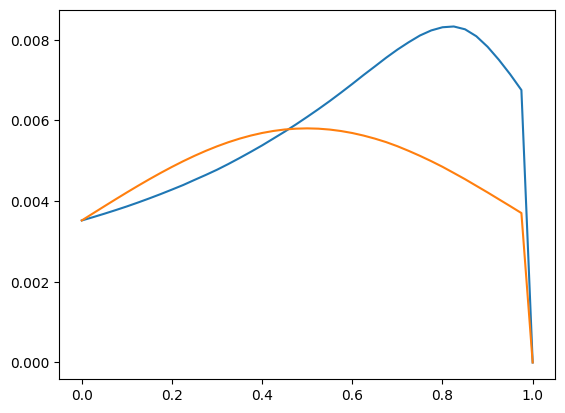

In [98]:
cross_mean = np.mean(F, axis=0)
cross_std = np.std(F, axis=0)

# plt.plot(cross_mean + cross_std)
# plt.plot(cross_mean - cross_std)
# plt.plot(F[(F<cross_mean+0.5*cross_std) & (F>cross_mean-0.5*cross_std)])
gamma_atm = []
gamma_mean = []
for i, t in enumerate(sim_results['time_grid']):
    cross_section = F[:, i]
    gamma_cross = sim_results['gamma'][:, i]
    gamma_sub = gamma_cross[(cross_section<cross_mean[i]+0.5*cross_std[i]) & (cross_section>cross_mean[i]-0.5*cross_std[i])]
    if len(gamma_sub) > 0:
        gamma_atm.append(np.mean(gamma_sub))
    else:
        if i == 0:
            gamma_atm.append(objBS.gamma(100, 0, sigma))
        if i == len(sim_results['time_grid']) - 1:
            gamma_atm.append(np.float('nan'))
        else:
            print(i, t)
    gamma_mean.append(np.mean(gamma_cross))
plt.plot(sim_results['time_grid'], gamma_atm)
plt.plot(sim_results['time_grid'], gamma_mean)

In [101]:
import numpy as np
from scipy.stats import norm
import unittest

class TestBlackScholesPricer(unittest.TestCase):
    
    def setUp(self):
        """Initialize default parameters for tests"""
        self.K = 100  # Strike price
        self.T = 1    # Time to expiry (1 year)
        self.r = 0.00 # Risk-free rate
        self.sigma = 0.2  # Volatility
        self.F_atm = 100  # ATM Forward price
        self.F_itm = 200  # ITM Forward price (for call)
        self.F_otm = 50   # OTM Forward price (for call)
        self.F_deep_itm = 550  # Deep ITM Forward price
        self.F_deep_otm = 5   # Deep OTM Forward price

    def test_price(self):
        """Verify option prices with known theoretical properties"""
        pricer_call = BlackScholesPricer(self.K, self.T, "C", self.r)
        pricer_put = BlackScholesPricer(self.K, self.T, "P", self.r)
        
        # Verify deep ITM call price is close to F - PV(K)
        call_price_itm = pricer_call.price(self.F_itm, 0, self.sigma)
        self.assertAlmostEqual(call_price_itm, self.F_itm - np.exp(-self.r * self.T) * self.K, delta=1e-2)
        
        # Verify deep ITM put price is close to PV(K) - F
        put_price_itm = pricer_put.price(self.F_otm, 0, self.sigma)
        self.assertAlmostEqual(put_price_itm, np.exp(-self.r * self.T) * self.K - self.F_otm, delta=1e-2)
        
        # Verify at expiry, price is intrinsic value
        call_price_exp = pricer_call.price(self.F_itm, self.T, self.sigma)
        self.assertEqual(call_price_exp, max(self.F_itm - self.K, 0))
        
        put_price_exp = pricer_put.price(self.F_otm, self.T, self.sigma)
        self.assertEqual(put_price_exp, max(self.K - self.F_otm, 0))
    
    def test_delta(self):
        """Verify delta values against expected theoretical values"""
        pricer_call = BlackScholesPricer(self.K, self.T, "C", self.r)
        pricer_put = BlackScholesPricer(self.K, self.T, "P", self.r)
        
        delta_atm_call = pricer_call.delta(self.F_atm, 0, self.sigma)
        delta_atm_put = pricer_put.delta(self.F_atm, 0, self.sigma)
        
        # Adjust expected values to account for risk-free rate effects
        expected_delta_call = norm.cdf((np.log(self.F_atm/self.K) + (self.sigma**2/2)*self.T) / (self.sigma*np.sqrt(self.T)))
        expected_delta_put = expected_delta_call - 1
        
        self.assertAlmostEqual(delta_atm_call, expected_delta_call, delta=0.05)
        self.assertAlmostEqual(delta_atm_put, expected_delta_put, delta=0.05)
    
    def test_greeks_vs_time(self):
        """Verify that greeks and price change correctly as expiry approaches"""
        pricer = BlackScholesPricer(self.K, self.T, "C", self.r)
        time_steps = np.linspace(0, self.T, 5)
        previous_price = None
        previous_delta = None
        
        for t in time_steps:
            price = pricer.price(self.F_atm, t, self.sigma)
            delta = pricer.delta(self.F_atm, t, self.sigma)
            
            if previous_price is not None:
                self.assertLessEqual(price, previous_price + 1e-6)  # Allow for floating point precision errors
                self.assertGreaterEqual(delta, previous_delta - 1e-6)  # Delta should move towards intrinsic value
            
            previous_price = price
            previous_delta = delta
            
        self.assertAlmostEqual(pricer.price(self.F_atm, self.T, self.sigma), max(self.F_atm - self.K, 0))
    
    def test_pnl_profile(self):
        """Verify that PNL profile values are internally consistent"""
        pricer = BlackScholesPricer(self.K, self.T, "C", self.r)
        profile = pricer.compute_pnl_profile_vs_F(self.F_atm, 0, self.sigma)
        
        self.assertTrue(hasattr(profile, 'F_nodes'))
        self.assertTrue(hasattr(profile, 'prices'))
        self.assertTrue(hasattr(profile, 'deltas'))
        self.assertEqual(len(profile.F_nodes), 101)
        self.assertEqual(len(profile.prices), 101)
        self.assertEqual(len(profile.deltas), 101)
    
suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestBlackScholesPricer)
unittest.TextTestRunner(verbosity=2).run(suite)

test_delta (__main__.TestBlackScholesPricer)
Verify delta values against expected theoretical values ... ok


test_greeks_vs_time (__main__.TestBlackScholesPricer)
Verify that greeks and price change correctly as expiry approaches ... FAIL
test_pnl_profile (__main__.TestBlackScholesPricer)
Verify that PNL profile values are internally consistent ... FAIL
test_price (__main__.TestBlackScholesPricer)
Verify option prices with known theoretical properties ... ok

FAIL: test_greeks_vs_time (__main__.TestBlackScholesPricer)
Verify that greeks and price change correctly as expiry approaches
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\tamaghna\AppData\Local\Temp\ipykernel_14528\1618522441.py", line 67, in test_greeks_vs_time
    self.assertGreaterEqual(delta, previous_delta - 1e-6)  # Delta should move towards intrinsic value
AssertionError: np.float64(0.5345062767202164) not greater than or equal to np.float64(0.539826837277029)

FAIL: test_pnl_profile (__main__.TestBlackScholesPricer)
Verify that PNL profile values are i

<unittest.runner.TextTestResult run=4 errors=0 failures=2>